Привет, меня зовут Артем Носенко и я буду проверять твой проект.
<br>Небольшая вступительная часть и начнем работу)
<br> Если не против, то предлагаю общаться на «ты». Если это не удобно - дай знать, и мы перейдем на "вы". Моя основная цель — не указать на совершенные ошибки, а поделиться своим опытом и помочь сделать твой проект лучше. Для этого я буду использовать разный стиль оформления комментариев.
<div class="alert alert-block alert-success">
✔️ Все хорошо.
</div>

<div class="alert alert-warning">
⚠️ Критических замечаний нет, но есть возможность сделать твою работу лучше.
</div>

<div class="alert alert-block alert-danger">
❌ Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>


Давай работать над проектом в диалоге: если ты что-то меняешь в проекте по моим рекомендациям — пиши об этом.
Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> ...
</div>
Пожалуйста, не перемещай, не изменяй и не удаляй мои комментарии. Всё это поможет выполнить повторную проверку твоего проекта оперативнее».
`


S3_BUCKET_NAME=s3-student-mle-20240525-e85d25cb1f

# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

Любой этап:

In [1]:
import gc
import pickle

In [2]:
import numpy as np
import pandas as pd
import scipy

In [3]:
from sklearn.preprocessing import LabelEncoder, normalize

from implicit.als import AlternatingLeastSquares

from catboost import CatBoostClassifier, Pool

/home/mle-user/mle_projects_final/mle-project-sprint-4-v001/.env_recsys_start/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


EDA:

In [4]:
import boto3
import os

In [4]:
import matplotlib.pyplot as plt

In [6]:
from dotenv import load_dotenv
load_dotenv()

True


<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
✔️ Основные импорты сделаны, отлично!

Импорты стоит делать в одной ячейке и группировать по типам. Вот [тут](https://peps.python.org/pep-0008/#imports:~:text=Imports%20should%20be,library%20specific%20imports.) можно посмотреть, как в стандарте PEP8 оформляются импорты.
    
</div>

Самописные утилиты

In [7]:
def show_dtypes(df: pd.DataFrame, samples:int = 3) -> pd.DataFrame:
    return pd.merge(
        df.dtypes.astype(str).to_frame(name="type").reset_index().sort_values("type"),
        df.isna().sum().to_frame(name="isna").reset_index()
    ).merge(
        df.head(samples).T.reset_index()
    )

---

Отсюда можно выполнить код:
- последовательно Этап 1 и Этап 2
- сразу перейти к Этап 3

---

# === ЭТАП 1 ===

## Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [8]:
# 30 sec

df_tracks = pd.read_parquet("tracks.parquet")
print("'tracks.parquet' loaded")
df_catalog = pd.read_parquet("catalog_names.parquet")
print("'catalog_names.parquet' loaded")
df_events = pd.read_parquet("interactions.parquet")
print("'interactions.parquet' loaded")

'tracks.parquet' loaded
'catalog_names.parquet' loaded
'interactions.parquet' loaded


## Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

### Данные о треках

In [9]:
# Размер таблицы
# (1000000, 4)

df_tracks.shape

(1000000, 4)

In [10]:
# Пропуски, Типы, Примеры данных

show_dtypes(df_tracks, 5)

,index,type,isna,0,1,2,3,4
0,track_id,int64,0,26,38,135,136,138
1,albums,object,0,"[3, 2490753]","[3, 2490753]","[12, 214, 2490809]","[12, 214, 2490809]","[12, 214, 322, 72275, 72292, 91199, 213505, 24..."
2,artists,object,0,[16],[16],[84],[84],[84]
3,genres,object,0,"[11, 21]","[11, 21]",[11],[11],[11]


In [11]:
# Кол-во уникальных треков
# 1000000

df_tracks["track_id"].nunique()

1000000

In [12]:
# Индексы треков
# (True, 26, 101521819)

df_tracks["track_id"].is_monotonic_increasing, df_tracks["track_id"].min(), df_tracks["track_id"].max()

(True, 26, 101521819)

In [13]:
# 2 min !
# Дубликаты
# 0

df_tracks.astype(str).duplicated().sum()

0

### Имена исполнителей, названия альбомов, треков и жанров

In [14]:
# Размер таблицы
# (1812471, 3)

df_catalog.shape

(1812471, 3)

In [15]:
# Пропуски, Типы, Примеры данных

show_dtypes(df_catalog, 5)

,index,type,isna,0,1,2,3,4
0,id,int64,0,3,12,13,17,26
1,type,object,0,album,album,album,album,album
2,name,object,0,Taller Children,Wild Young Hearts,Lonesome Crow,Graffiti Soul,Blues Six Pack


In [16]:
# Кол-во уникальных значений
# id      1776697
# type          4
# name     945118

df_catalog.nunique()

id      1776697
type          4
name     945118
dtype: int64

In [17]:
# Типы
# ['album', 'artist', 'genre', 'track']

df_catalog["type"].unique()

array(['album', 'artist', 'genre', 'track'], dtype=object)

In [18]:
# Дубликаты
# 0

df_catalog.duplicated().sum()

0

### Данные о том, какие пользователи прослушали тот или иной трек

In [19]:
# Размер таблицы
# (222629898, 4)

df_events.shape

(222629898, 4)

In [20]:
# Пропуски, Типы, Примеры данных

show_dtypes(df_events, 5)

,index,type,isna,0,1,2,3,4
0,started_at,datetime64[ns],0,2022-07-17 00:00:00,2022-07-19 00:00:00,2022-07-21 00:00:00,2022-07-22 00:00:00,2022-07-22 00:00:00
1,track_seq,int16,0,1,2,3,4,5
2,user_id,int32,0,0,0,0,0,0
3,track_id,int32,0,99262,589498,590262,590303,590692


In [21]:
# Кол-во уникальных значений
# user_id       1373221
# track_id      1000000
# track_seq       16637
# started_at        365

df_events.nunique()

user_id       1373221
track_id      1000000
track_seq       16637
started_at        365
dtype: int64

In [22]:
# 2 min !
# Дубликаты
# 0

df_events.duplicated().sum()

0

## Выводы


- Пропуски в данных отсутствуют
- Дубликаты отсутствуют
- Типы данных соответствуют
- Полный размер матрицы взаимодействий:
  - **1 373 221** пользователей
  - **1 000 000** треков
- При подготовке данных переименовать `track_id` в общепринятое обозначение объектов взаимодействия `item_id`


<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Отлично, первичный анализ данных проведен! Выводы корректные.
</div>

<div class="alert alert-warning">
⚠️ На подумать: возможно стоило сжать некоторые типы данных. Например, перейти от использования int32 на int16 или int8. Это позволило

# === ЭТАП 2 ===

## EDA

Информация по названиям треков и исполнителям

In [23]:
# 2 min !

df_track_info = (
    df_tracks
    .merge(
        df_catalog.loc[df_catalog["type"]=="track", ["id", "name"]].rename(columns={"id": "track_id", "name": "track_name"}),
        on="track_id",
        how="left",
    )
    .merge(
        (
            df_tracks[["track_id", "artists"]]
            .explode("artists")
            .merge(
                df_catalog.loc[df_catalog["type"]=="artist", ["id", "name"]].rename(columns={"id": "artists", "name": "artist_names"}),
                on="artists",
                how="left"
            )
            .groupby("track_id", as_index=False)["artist_names"].apply(lambda x: '; '.join(x.astype(str)))
        ),
        on="track_id",
        how="left",
    )
    [["track_id", "track_name", "artist_names"]]
)

In [24]:
# (1000000, 3)
df_track_info.shape

(1000000, 3)

In [25]:
df_track_info.head()

,track_id,track_name,artist_names
0,26,Complimentary Me,Elizabeth & the Catapult
1,38,Momma's Boy,Elizabeth & the Catapult
2,135,Atticus,Noisettes
3,136,24 Hours,Noisettes
4,138,Don't Upset The Rhythm (Go Baby Go),Noisettes


<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ ОК! Все собрано в одном месте!
</div>

### Каталог

In [26]:
# album      658724
# artist     153581
# genre         166
# track     1000000

df_catalog.groupby("type")["id"].nunique()

type
album      658724
artist     153581
genre         166
track     1000000
Name: id, dtype: int64

In [27]:
# 658724

df_tracks["albums"].explode().nunique()

658724

In [28]:
# 153581

df_tracks["artists"].explode().nunique()

153581

In [29]:
# 173

df_tracks["genres"].explode().nunique()

173

In [30]:
set(df_tracks["track_id"].explode()) ^ set(df_catalog.loc[df_catalog["type"]=="track", "id"])

set()

In [31]:
set(df_tracks["albums"].explode()) ^ set(df_catalog.loc[df_catalog["type"]=="album", "id"])

{nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan}

In [32]:
(df_tracks["albums"].apply(len) == 0).sum()

18

In [33]:
set(df_tracks["artists"].explode()) ^ set(df_catalog.loc[df_catalog["type"]=="artist", "id"])

{nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [34]:
(df_tracks["artists"].apply(len) == 0).sum()

15369

In [35]:
set(df_tracks["genres"].explode()) ^ set(df_catalog.loc[df_catalog["type"]=="getnre", "id"])

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 nan,
 31,
 32,
 33,
 nan,
 35,
 30,
 37,
 38,
 39,
 40,
 41,
 nan,
 43,
 44,
 45,
 nan,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 nan,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 62,
 nan,
 73,
 74,
 75,
 nan,
 nan,
 76,
 nan,
 nan,
 nan,
 80,
 77,
 79,
 85,
 86,
 nan,
 88,
 89,
 nan,
 nan,
 92,
 90,
 94,
 95,
 87,
 97,
 98,
 99,
 nan,
 101,
 102,
 nan,
 104,
 nan,
 nan,
 nan,
 nan,
 109,
 nan,
 nan,
 112,
 113,
 114,
 nan,
 116,
 117,
 118,
 nan,
 120,
 115,
 121,
 nan,
 124,
 nan,
 126,
 127,
 128,
 nan,
 nan,
 130,
 132,
 133,
 134,
 nan,
 131,
 nan,
 138,
 135,
 nan,
 nan,
 nan,
 146,
 nan,
 148,
 nan,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 nan,
 167,
 168,
 169,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 190,
 nan,
 nan,
 nan,
 n

In [36]:
(df_tracks["genres"].apply(len) == 0).sum()

3687

**Выводы:**
- Кол-во треков в каталоге соответствует кол-ву треков в данных
- Альбомы в каталоге соответствует альбомам в данных по трекам
- Испольнители в каталоге соответствует исполнителям в данных по трекам
- ***Жанров в данных по трекам больше, чем в каталоге***
- В данных по треакам имеется ***18 треков без альбома***
- В данных по треакам имеется ***15369 треков без исполнителя***
- В данных по треакам имеется ***3687 треков без жанра***


**Выводы 2:**
- При построении персональных рекомендации моделью ALS на ВМ умирает ядро. После 10 часов тщетных попыток построить рекомендации решение сократить матрицу:
  - Удаляме треки без альбомов
  - Удаляем треки без исполнителя
  - Удаляме треки без жанра

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Отлично, выводы корректные.
</div>

### Временной период в данных

In [37]:
# (Timestamp('2022-01-01 00:00:00'), Timestamp('2022-12-31 00:00:00'))

df_events["started_at"].min(), df_events["started_at"].max()

(Timestamp('2022-01-01 00:00:00'), Timestamp('2022-12-31 00:00:00'))

#### События по дням

In [38]:
# 3 min !

interactions_by_day = df_events.groupby("started_at", as_index=False).agg(
    n_events=("started_at", "count"),
    n_users=("user_id", "nunique"),
    n_items=("track_id", "nunique"),
)

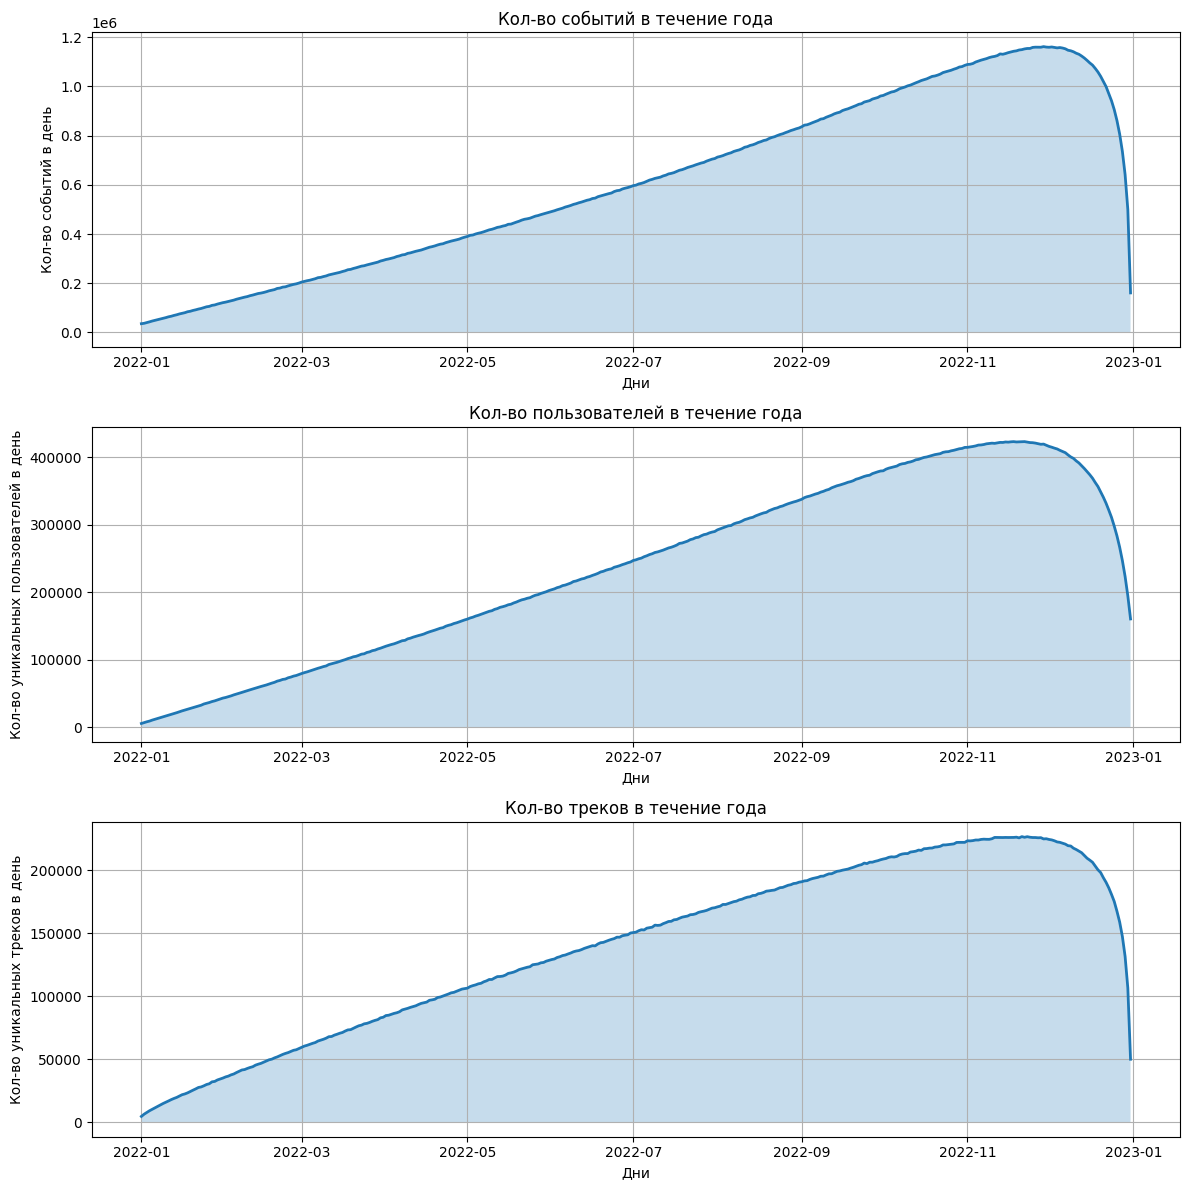

In [39]:
# распределение взаимодействий по дням

fig, axs = plt.subplots(3, 1, figsize=(12, 12))

axs[0].plot(interactions_by_day["started_at"], interactions_by_day["n_events"], linewidth=2)
axs[0].fill_between(interactions_by_day["started_at"], [0]*interactions_by_day.shape[0], interactions_by_day["n_events"], alpha=0.25)
axs[0].set_title("Кол-во событий в течение года")
axs[0].set_ylabel("Кол-во событий в день")
axs[0].set_xlabel("Дни")

axs[1].plot(interactions_by_day["started_at"], interactions_by_day["n_users"], linewidth=2)
axs[1].fill_between(interactions_by_day["started_at"], [0]*interactions_by_day.shape[0], interactions_by_day["n_users"], alpha=0.25)
axs[1].set_title("Кол-во пользователей в течение года")
axs[1].set_ylabel("Кол-во уникальных пользователей в день")
axs[1].set_xlabel("Дни")

axs[2].plot(interactions_by_day["started_at"], interactions_by_day["n_items"], linewidth=2)
axs[2].fill_between(interactions_by_day["started_at"], [0]*interactions_by_day.shape[0], interactions_by_day["n_items"], alpha=0.25)
axs[2].set_title("Кол-во треков в течение года")
axs[2].set_ylabel("Кол-во уникальных треков в день")
axs[2].set_xlabel("Дни")

for ax in axs:
    ax.grid("both")

fig.tight_layout()

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Отличные графики!
</div>

In [40]:
# Если взять в тест декабрь

df_test_temp = df_events[df_events["started_at"]>="2022-12-01"]
print("Кол-во клиентов в тесте:")
print(df_test_temp["user_id"].nunique())
print("Доля клиентов в тесте, которая есть в трейне:")
print(f'{df_events.loc[df_events["started_at"]<"2022-12-01", "user_id"].drop_duplicates().isin(df_test_temp["user_id"]).sum() / df_test_temp["user_id"].nunique():.2%}')

Кол-во клиентов в тесте:
995485
Доля клиентов в тесте, которая есть в трейне:
92.14%


In [41]:
# Если взять в тест ноябрь

df_test_temp = df_events[(df_events["started_at"]>="2022-11-01") & (df_events["started_at"]<"2022-12-01")]
print("Кол-во клиентов в тесте:")
print(df_test_temp["user_id"].nunique())
print("Доля клиентов в тесте, которая есть в трейне:")
print(f'{df_events.loc[df_events["started_at"]<"2022-11-01", "user_id"].drop_duplicates().isin(df_test_temp["user_id"]).sum() / df_test_temp["user_id"].nunique():.2%}')

Кол-во клиентов в тесте:
1081320
Доля клиентов в тесте, которая есть в трейне:
90.16%


In [42]:
del interactions_by_day, df_test_temp
gc.collect()

65

In [43]:
# 1.062882386952999

(1081320 * 0.9016) / (995485 * 0.9214)

1.062882386952999

**Выводы:**
- Имеем данные о взаимодйствиях пользоватлей за период всего 2022 года (365 дней)
- До декабря наблюдается линейный рост кол-ва уникальных клиентов, а с конца ноября - начала декабря наблюдается спад кол-ва уникальных пользователей и соответственно уникальных треков и событий взаимодействия пользователей с треками
- Если взять в тест ноябрь, то кол-во оцениваемых клиентов на тесте больше на 6%, при этом потеряем ценную историю взаимодействий в 1 месяц. Поэтому в тест лучше брать период декабря

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Ок!
</div>

### Распределение количества прослушанных треков.

In [44]:
# 2 min

users_tracks = (
    df_events.groupby("user_id")
    .agg(
        n_tracks = ("track_id", "nunique"),
        max_seq = ("track_seq", "max"),
        min_date = ("started_at", "min"),
        max_date = ("started_at", "max"),
    )
)

In [45]:
users_tracks.head()

,n_tracks,max_seq,min_date,max_date
user_id,,,,
0,26,26,2022-07-17,2022-09-15
1,36,36,2022-06-11,2022-07-28
2,14,14,2022-04-15,2022-08-30
3,33,33,2022-02-05,2022-12-20
4,256,256,2022-03-29,2022-12-29


In [46]:
# Проверка: соответствует ли последовательность прослушивания треков кол-ву прслушанных треков

assert all(users_tracks["n_tracks"] == users_tracks["max_seq"])

Если кол-во уникальных равно кол-ву прослушанных, то ни один клиент не слушал ни одного трека повтроно

In [47]:
users_tracks["n_tracks"].describe().to_frame().style.format('{:.1f}')

,n_tracks
count,1373221.0
mean,162.1
std,351.3
min,1.0
25%,23.0
50%,55.0
75%,154.0
max,16637.0


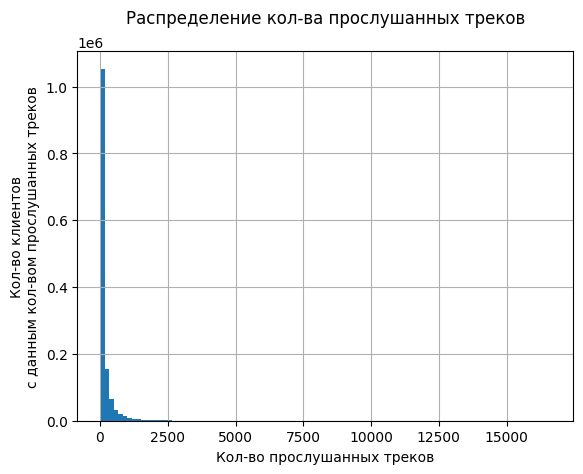

In [48]:
users_tracks["n_tracks"].hist(bins=100)

plt.title("Распределение кол-ва прослушанных треков", pad=20)
plt.xlabel("Кол-во прослушанных треков")
plt.ylabel("Кол-во клиентов\nс данным кол-вом прослушанных треков")
plt.show()

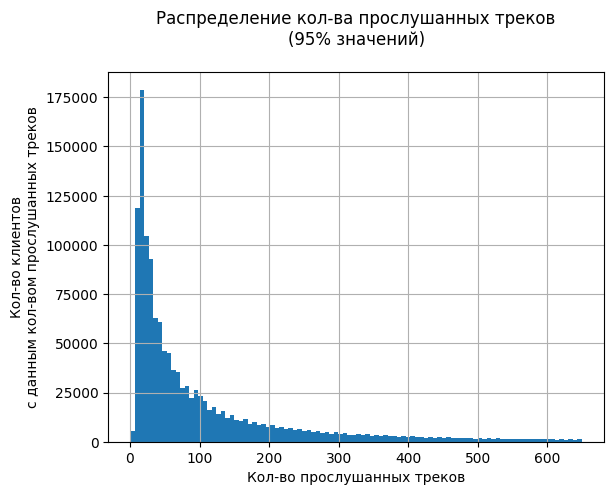

In [49]:
users_tracks.loc[users_tracks["n_tracks"] < users_tracks["n_tracks"].quantile(0.95), "n_tracks"].hist(bins=100)

plt.title("Распределение кол-ва прослушанных треков\n(95% значений)", pad=20)
plt.xlabel("Кол-во прослушанных треков")
plt.ylabel("Кол-во клиентов\nс данным кол-вом прослушанных треков")
plt.show()

In [50]:
pd.concat([
    users_tracks["n_tracks"].value_counts(normalize=True).sort_index().head(20),
    users_tracks["n_tracks"].value_counts(normalize=True).sort_index().head(20).cumsum(),
], axis=1)

,proportion,proportion
n_tracks,,
1,0.000618,0.000618
2,0.000531,0.001149
3,0.000484,0.001633
4,0.000509,0.002142
5,0.000492,0.002634
6,0.000610,0.003243
7,0.000695,0.003939
8,0.000936,0.004875
9,0.001462,0.006337


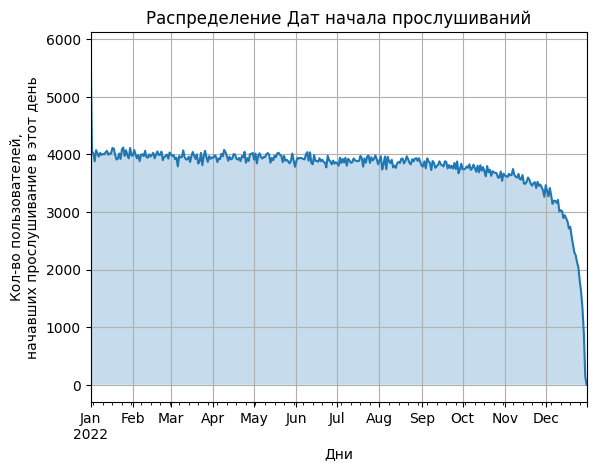

In [51]:
df_plot = users_tracks["min_date"].value_counts().sort_index()
df_plot.plot()
plt.fill_between(df_plot.index, [0]*df_plot.shape[0], df_plot, alpha=0.25)

plt.grid("both")
plt.title("Распределение Дат начала прослушиваний")
plt.ylabel("Кол-во пользователей,\nначавших прослушивание в этот день")
plt.xlabel("Дни")
plt.show()

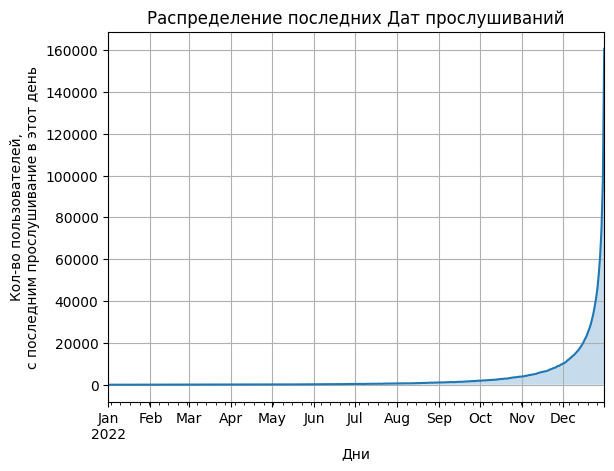

In [52]:
df_plot = users_tracks["max_date"].value_counts().sort_index()
df_plot.plot()
plt.fill_between(df_plot.index, [0]*df_plot.shape[0], df_plot, alpha=0.25)

plt.grid("both")
plt.title("Распределение последних Дат прослушиваний")
plt.ylabel("Кол-во пользователей,\nс последним прослушивание в этот день")
plt.xlabel("Дни")
plt.show()

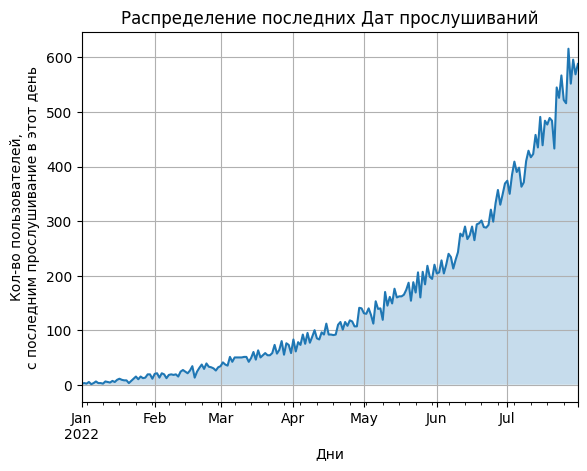

In [53]:
df_plot = users_tracks.loc[users_tracks["max_date"] < '2022-08-01', "max_date"].value_counts().sort_index()
df_plot.plot()
plt.fill_between(df_plot.index, [0]*df_plot.shape[0], df_plot, alpha=0.25)

plt.grid("both")
plt.title("Распределение последних Дат прослушиваний")
plt.ylabel("Кол-во пользователей,\nс последним прослушивание в этот день")
plt.xlabel("Дни")
plt.show()

In [54]:
del df_plot, users_tracks
gc.collect()

43970

**Выводы:**
- Пользователи не слушают треки повторно (оценки по кол-ву прослушиваний одного трека не построить)
- В среднем пользователи прослушивают 162 трека за год
- Медиана прослушиваний за год = 55 треков
- Минимум прослешиваний за год = 1 трек
- Максимум прослушиваний за год = 16 637 треков
- 10 и менее прослушанных треков имеют менее 1% пользователей - можно отбросить этих пользователей
- до ноября стабильно ежедневно присоединяются к сервису поярдка 4000 новых пользователей, затем идет резкое снижение новых пользователей

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Верно, графики отличные, выводы правильные!
</div>

<div class="alert alert-warning">
⚠️ На подумать: возможно стоит для пользователей, у которых 10 и менее прослушанных треков делать неперсональные рекомендации, а не совсем удалять их из выборки.
</div>

**Выводы 2:**
- При построении персональных рекомендации моделью ALS на ВМ умирает ядро. После 10 часов тщетных попыток построить рекомендации решение сократить матрицу:
  - Оставляем клиентов с количеством прослушанных треков не менее 10 и не более 650. Т.е. обрежем выбросы: 1% снизу и 5% сверху.

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ ОК!
</div>

### Наиболее популярные треки

In [55]:
# 2 min

pop_tracks = df_events.groupby("track_id", as_index=False).agg(n_users=("user_id", "nunique"))

In [56]:
pop_tracks["pop_rating"] = pop_tracks["n_users"] / df_events["user_id"].nunique()

In [57]:
# (1000000, 3)

pop_tracks.shape

(1000000, 3)

In [58]:
pop_tracks.head()

,track_id,n_users,pop_rating
0,26,5,0.000004
1,38,8,0.000006
2,135,16,0.000012
3,136,7,0.000005
4,138,17,0.000012


Рассмотрим 20 наиболее популярных треков

In [59]:
pop_tracks.sort_values("n_users", ascending=False).head(20).merge(df_track_info)

,track_id,n_users,pop_rating,track_name,artist_names
0,53404,111062,0.080877,Smells Like Teen Spirit,Nirvana
1,33311009,106921,0.077861,Believer,Imagine Dragons
2,178529,101924,0.074223,Numb,Linkin Park
3,35505245,99490,0.072450,I Got Love,Miyagi & Эндшпиль; Рем Дигга
4,65851540,86670,0.063114,Юность,Dabro
5,24692821,86246,0.062806,Way Down We Go,KALEO
6,32947997,85886,0.062543,Shape of You,Ed Sheeran
7,51241318,85244,0.062076,In The End,Tommee Profitt; Fleurie; Mellen Gi
8,795836,85042,0.061929,Shape Of My Heart,Sting
9,45499814,84748,0.061715,Life,Zivert


<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Топ треков выглядит логичным!
</div>

In [60]:
pd.concat([
    pop_tracks["n_users"].value_counts(normalize=True).sort_index().head(20),
    pop_tracks["n_users"].value_counts(normalize=True).sort_index().head(20).cumsum(),
], axis=1)

,proportion,proportion
n_users,,
5,0.053790,0.053790
6,0.078428,0.132218
7,0.061507,0.193725
8,0.050066,0.243791
9,0.041822,0.285613
10,0.035885,0.321498
11,0.031282,0.352780
12,0.027301,0.380081
13,0.024535,0.404616


In [61]:
pop_tracks["n_users"].min()

5

In [62]:
# del pop_tracks  # пригодится на поиске наиболее популярных жанров и исполнителей
# gc.collect()

**Вывод:**
- Наиболее популярные треки:
  - Nirvana "Smells Like Teen Spirit"
  - Imagine Dragons "Believer"
  - Linkin Park "Numb"

**Выводы 2:**
- При построении персональных рекомендации моделью ALS на ВМ умирает ядро. После 10 часов тщетных попыток построить рекомендации решение сократить матрицу:
  - Удаляем треки, которые прослушивали менее 10 раз

### Наиболее популярные жанры

In [63]:
# Ядро падает:

# pop_genres = (
#     df_events[["track_id"]]
#     .merge(
#         df_tracks[["track_id", "genres"]].explode("genres"),
#         on="track_id",
#         how="left",
#     )
#     ["genres"].value_counts()
# )

In [64]:
pop_genres = (
    pop_tracks[["track_id", "n_users"]]
    .merge(
        df_tracks[["track_id", "genres"]].explode("genres"),
        on="track_id",
        how="left",
    )
    .groupby("genres", as_index=False)["n_users"].sum()
)

In [65]:
pop_genres["pop_rating"] = pop_genres["n_users"] / pop_genres["n_users"].sum()

In [66]:
# (173, 3)

pop_genres.shape

(173, 3)

In [67]:
pop_genres.head()

,genres,n_users,pop_rating
0,1,103086,0.000274
1,2,13166147,0.034965
2,3,25303695,0.067198
3,4,213528,0.000567
4,5,774668,0.002057


In [68]:
pop_genres.tail()

,genres,n_users,pop_rating
168,1016,228315,0.000606
169,1182,35013,0.000093
170,1197,137301,0.000365
171,1484,57787,0.000153
172,1542,9881,0.000026


Рассмотрим 20 наиболее популярных жанров

In [69]:
(
    pop_genres
    .sort_values("n_users", ascending=False)
    .head(20)
    .merge(
        df_catalog.loc[df_catalog["type"]=="genre", ["id", "name"]].rename(columns={"id": "genres", "name": "genre_name"}),
        on="genres",
        how="left",
    )
)

,genres,n_users,pop_rating,genre_name
0,11,55578312,0.147597,pop
1,75,37799821,0.100383,rap
2,102,31092013,0.082570,allrock
3,20,26626241,0.070710,ruspop
4,3,25303695,0.067198,rusrap
5,68,20120981,0.053434,electronics
6,16,16291557,0.043265,dance
7,2,13166147,0.034965,rusrock
8,14,12772644,0.033920,rock
9,47,12437375,0.033029,metal


In [70]:
del pop_genres
gc.collect()

0

**Вывод:**
- Наиболее популярные жарны:
  - Поп
  - Рэп
  - allrock

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Ок, отлично!
</div>

### Наиболее популярные исполнители

In [71]:
pop_artists = (
    pop_tracks[["track_id", "n_users"]]
    .merge(
        df_tracks[["track_id", "artists"]].explode("artists"),
        on="track_id",
        how="left",
    )
    .groupby("artists", as_index=False)["n_users"].sum()
)

In [72]:
pop_artists["pop_rating"] = pop_artists["n_users"] / pop_artists["n_users"].sum()

In [73]:
# (153581, 3)

pop_artists.shape

(153581, 3)

In [74]:
pop_artists.head()

,artists,n_users,pop_rating
0,4,39,1.366340e-07
1,5,164,5.745633e-07
2,7,7,2.452404e-08
3,9,73794,2.585325e-04
4,12,5,1.751717e-08


Рассмотрим 20 наиболее популярных исполнителей

In [75]:
(
    pop_artists
    .sort_values("n_users", ascending=False)
    .head(20)
    .merge(
        df_catalog.loc[df_catalog["type"]=="artist", ["id", "name"]].rename(columns={"id": "artists", "name": "artist_name"}),
        on="artists",
        how="left",
    )
)

,artists,n_users,pop_rating,artist_name
0,41191,886086,0.003104,Баста
1,41114,831788,0.002914,Би-2
2,3246342,828217,0.002902,Скриптонит
3,675068,804918,0.002820,Imagine Dragons
4,41075,795072,0.002785,КИНО
5,41052,748064,0.002621,Король и Шут
6,975699,717773,0.002515,Макс Корж
7,4611844,677548,0.002374,Miyagi & Эндшпиль
8,666984,676222,0.002369,Artik & Asti
9,36800,675728,0.002367,Linkin Park


In [76]:
del pop_artists
gc.collect()

0

**Вывод:**
- Наиболее популярные исполнители:
  - Баста
  - Би-2
  - Скриптонит

### Треки, которые никто не прослушал

In [77]:
# 1000000

df_events["track_id"].nunique()

1000000

In [78]:
# empty DataFrame

df_tracks.loc[~df_tracks["track_id"].isin(df_events["track_id"].unique())]

,track_id,albums,artists,genres


**Вывод:**
- Треков, которые никто не прослушал нет в данных

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Отлично!
</div>

## Преобразование данных

In [79]:
# 222629898

shape_origin = df_events.shape[0]
shape_origin

222629898

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [80]:
# Добавим наименования к данным по трекам

df_tracks = df_tracks.merge(
    df_track_info,
    on="track_id",
    how="left",
)

In [81]:
# Оставим клиентов с не менее 10 и не более 650 прослушанными треками

# Падает ядро:
# df_events.groupby("user_id").filter(lambda x: x["track_seq"].max() > 10)

df_events = df_events.loc[df_events["user_id"].isin(
    df_events.loc[(df_events["track_seq"] > 10) & (df_events["track_seq"] <= 650), "user_id"].unique()
)]

In [82]:
# Удаляем треки без жанра, исполнителя или альбома

df_tracks = df_tracks[df_tracks["albums"].apply(len) > 0]
df_tracks = df_tracks[df_tracks["artists"].apply(len) > 0]
df_tracks = df_tracks[df_tracks["genres"].apply(len) > 0]

In [83]:
# Оставляем треки, которые прослушивали не менее 10 раз

df_tracks = df_tracks[df_tracks["track_id"].isin(
    pop_tracks.loc[pop_tracks["n_users"] >= 10, "track_id"]
)]

In [84]:
df_events = df_events[df_events["track_id"].isin(df_tracks["track_id"])]

In [85]:
# Переименуем колонки

df_events = df_events.rename(columns={
    "track_id": "item_id_origin",
    "track_seq": "item_seq",
    "user_id": "user_id_origin",
})
df_tracks = df_tracks.rename(columns={
    "track_id": "item_id_origin",
})

In [86]:
# 2 min !
# Преобразуем идентификаторы пользователей и товаров в непрерывную последовательность

user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

df_events["user_id"] = user_encoder.fit_transform(df_events["user_id_origin"])

item_encoder.fit(df_tracks["item_id_origin"])
df_tracks["item_id"] = item_encoder.transform(df_tracks["item_id_origin"])
df_events["item_id"] = item_encoder.transform(df_events["item_id_origin"])

In [87]:
# Добавим рейтинги
# Поскольку пользователи не прослушивали трек дважды, то все оценки = 1 (см. ### Распределение количества прослушанных треков.)

df_events["ratings"] = 1

In [88]:
# Обзор результата

pd.concat([
    df_tracks.head(),
    df_tracks.tail()
])

,item_id_origin,albums,artists,genres,track_name,artist_names,item_id
2,135,"[12, 214, 2490809]",[84],[11],Atticus,Noisettes,0
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],Don't Upset The Rhythm (Go Baby Go),Noisettes,1
6,140,"[12, 214, 2490809]",[84],[11],Sometimes,Noisettes,2
7,141,"[12, 214, 60093, 2490809, 10023160, 15635235, ...",[84],[11],Never Forget You,Noisettes,3
8,143,"[12, 214, 2490809]",[84],[11],Every Now And Then,Noisettes,4
999993,101458360,[21394533],"[314001, 40324, 7237963]",[13],KULT,grandson; Steve Aoki; Jasiah,703754
999994,101476180,[21399110],[6207325],"[11, 20]",Февраль,Gafur,703755
999996,101490148,[21403052],[9078726],"[11, 20]",Без капли мысли,Даня Милохин,703756
999998,101495927,[21404975],[4462686],"[3, 75]",Москва,Yanix,703757
999999,101521819,[21414638],[5056591],"[3, 75]",Вокзал,Джарахов,703758


In [89]:
# Обзор результата

pd.concat([
    df_events.head(),
    df_events.tail()
])

,user_id_origin,item_id_origin,item_seq,started_at,user_id,item_id,ratings
0,0,99262,1,2022-07-17,0,12482,1
1,0,589498,2,2022-07-19,0,45093,1
2,0,590262,3,2022-07-21,0,45483,1
3,0,590303,4,2022-07-22,0,45503,1
4,0,590692,5,2022-07-22,0,45693,1
287,1374582,95514767,288,2022-12-29,1359367,695976,1
288,1374582,97220301,289,2022-12-29,1359367,698975,1
289,1374582,97241171,290,2022-12-29,1359367,699026,1
290,1374582,98542641,291,2022-12-29,1359367,700940,1
291,1374582,100736375,292,2022-12-30,1359367,703430,1


In [90]:
# (703759, 7)

df_tracks.shape

(703759, 7)

In [91]:
# 1359368

df_events["user_id"].nunique()

1359368

In [92]:
df_events.shape[0] / shape_origin

0.9891261190803762

Потеря данных по взаимодействиям менее 2%

## Сохранение данных

Сохраним словари для декодированных идентификаторов

In [93]:
df_tracks[["item_id_origin", "item_id"]].reset_index(drop=True).to_parquet("id_dict_items.parquet")

In [94]:
df_events[["user_id_origin", "user_id"]].drop_duplicates().reset_index(drop=True).to_parquet("id_dict_users.parquet")

In [95]:
df_tracks[['item_id', 'albums', 'artists', 'genres', 'track_name', 'artist_names']].to_parquet("items.parquet")

In [97]:
# 1 min !

df_events[['user_id', 'item_id', 'item_seq', 'started_at', 'ratings']].to_parquet("events.parquet")

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [98]:
session = boto3.session.Session()
s3 = boto3.client(
    service_name = 's3',
    endpoint_url='https://storage.yandexcloud.net',
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"))

bucket_name = os.getenv("S3_BUCKET_NAME")

In [99]:
s3.upload_file("items.parquet", bucket_name, "recsys/data/items.parquet")

In [100]:
s3.upload_file("events.parquet", bucket_name, "recsys/data/events.parquet")

In [101]:
s3.upload_file("id_dict_items.parquet", bucket_name, "recsys/data/id_dict_items.parquet")

In [102]:
s3.upload_file("id_dict_users.parquet", bucket_name, "recsys/data/id_dict_users.parquet")

In [105]:
# files = []
# sizes = []


# if s3.list_objects(Bucket=bucket_name).get('Contents'):
#     for key in s3.list_objects(Bucket=bucket_name)['Contents']:
#         cur_key = key['Key']
#         response = s3.head_object(Bucket = bucket_name, Key = cur_key)
#         cur_size = response['ContentLength']
#         print(f"file {cur_key} weights {cur_size} bytes")
#         files.append(cur_key)
#         sizes.append(cur_size)

# total_weight = sum(sizes)
# print(f"Total weight of all files in bucket = {total_weight}")

In [103]:
if s3.list_objects(Bucket=bucket_name).get('Contents'):
    for key in s3.list_objects(Bucket=bucket_name)['Contents']:
        cur_key = key['Key']
        response = s3.head_object(Bucket = bucket_name, Key = cur_key)
        cur_size = response['ContentLength']
        if cur_key.startswith("recsys"):
            print(f"file {cur_key} weights {cur_size} bytes")

file recsys/data/events.parquet weights 1454441905 bytes
file recsys/data/id_dict_items.parquet weights 6343130 bytes
file recsys/data/id_dict_users.parquet weights 12620419 bytes
file recsys/data/items.parquet weights 32987125 bytes
file recsys/recommendations/personal_als.parquet weights 815608866 bytes
file recsys/recommendations/similar.parquet weights 70678566 bytes
file recsys/recommendations/top_popular.parquet weights 3176 bytes


## Очистка памяти

- Cледует перезапустить kernel
- Выполнить раздел "# Инициализация" (т.е. все, что до раздела "# === ЭТАП 1 ===")

---

---

# === ЭТАП 3 ===

## Загрузка данных

Загружаем данные из файлов:
- items.parquet
- events.parquet
- catalog_names.parquet

In [4]:
df_catalog = pd.read_parquet("catalog_names.parquet")
print("'catalog_names.parquet' loaded")

'catalog_names.parquet' loaded


In [3]:
df_items = pd.read_parquet("items.parquet")
print("'items.parquet' loaded")

'items.parquet' loaded


In [3]:
df_events = pd.read_parquet("events.parquet")
print("'events.parquet' loaded")

'events.parquet' loaded


In [7]:
# (1812471, 3)

df_catalog.shape

(1812471, 3)

In [8]:
df_catalog.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [9]:
# (634033, 6)

df_items.shape

(703759, 6)

In [10]:
df_items.head()

,item_id,albums,artists,genres,track_name,artist_names
2,0,"[12, 214, 2490809]",[84],[11],Atticus,Noisettes
4,1,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],Don't Upset The Rhythm (Go Baby Go),Noisettes
6,2,"[12, 214, 2490809]",[84],[11],Sometimes,Noisettes
7,3,"[12, 214, 60093, 2490809, 10023160, 15635235, ...",[84],[11],Never Forget You,Noisettes
8,4,"[12, 214, 2490809]",[84],[11],Every Now And Then,Noisettes


In [11]:
# (44027021, 5)

df_events.shape

(220209047, 5)

In [12]:
df_events.head()

,user_id,item_id,item_seq,started_at,ratings
0,0,12482,1,2022-07-17,1
1,0,45093,2,2022-07-19,1
2,0,45483,3,2022-07-21,1
3,0,45503,4,2022-07-22,1
4,0,45693,5,2022-07-22,1


### Оптимизация памяти:

In [13]:
df_catalog["id"] = df_catalog["id"].astype("int32")

In [5]:
df_items["item_id"] = df_items["item_id"].astype("int32")

In [4]:
df_events["user_id"] = df_events["user_id"].astype("int32")
df_events["item_id"] = df_events["item_id"].astype("int32")
df_events["item_seq"] = df_events["item_seq"].astype("int16")
df_events["ratings"] = df_events["ratings"].astype("int8")

## Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

В тренировочную отнесем все данные до 16 декабря 2022 года (не включительно).

In [5]:
SPLIT_POINT_DATE = '2022-12-16'

In [6]:
df_events_train = df_events[df_events["started_at"] < SPLIT_POINT_DATE]
df_events_test = df_events[df_events["started_at"] >= SPLIT_POINT_DATE]

In [7]:
del df_events
gc.collect()

0

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
    
✔️ Отлично, выборки train / test сформированы. 

Выборки train / test можно получать несколькими способами (см. картинку ниже)
</div>

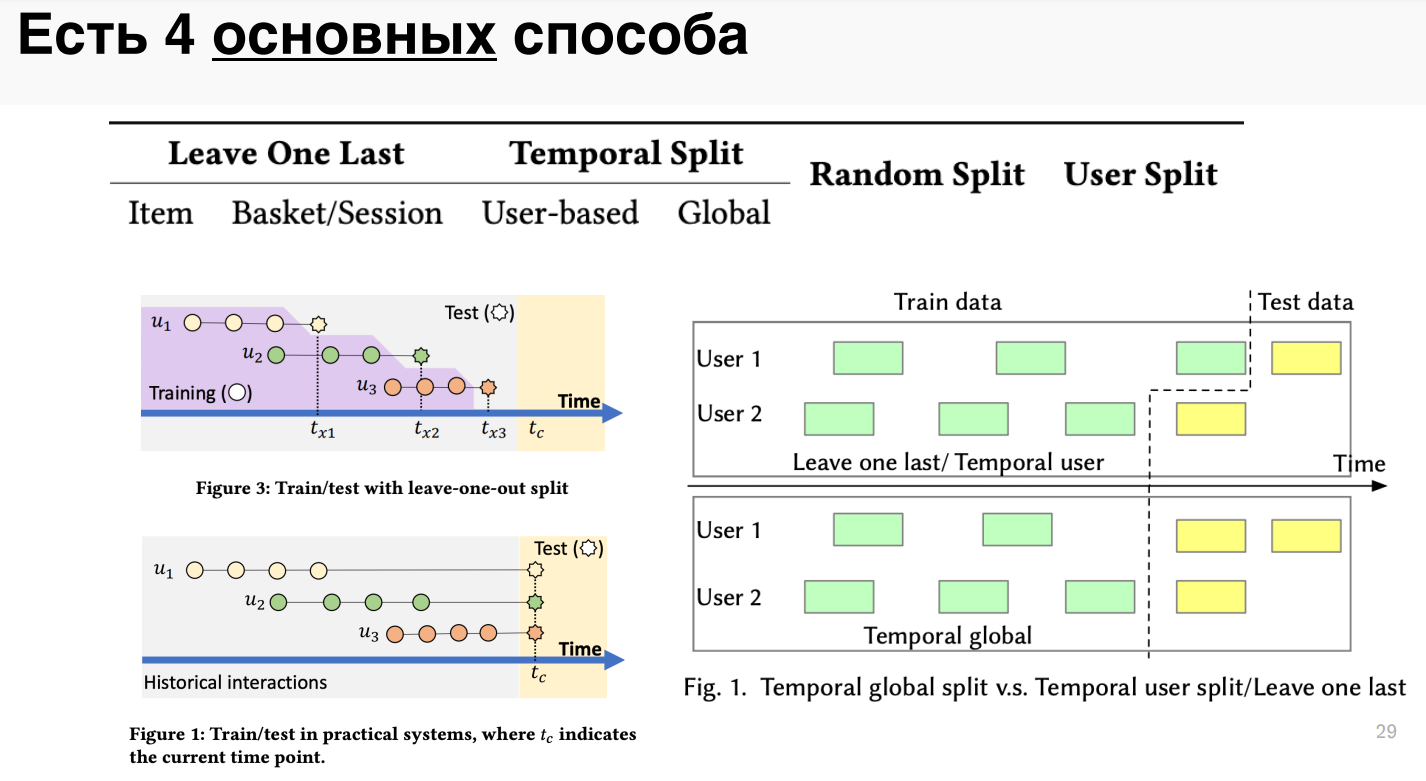

---

In [19]:
# Размеры выборок
# ((206 537 818, 5), (13 671 229, 5))

df_events_train.shape, df_events_test.shape

((206537818, 5), (13671229, 5))

In [20]:
# Кол-во клиентов в каждой выборке
# (1 329 305, 772 646)

df_events_train["user_id"].nunique(), df_events_test["user_id"].nunique()

(1329305, 772646)

In [21]:
# Клиенты в трейне и тесте
# (742583,)

common_users = np.intersect1d(df_events_train["user_id"].unique(), df_events_test["user_id"].unique())
common_users.shape

(742583,)

In [22]:
# "Холодные" пользователи
# (30063,)

cold_users = np.setdiff1d(df_events_test["user_id"].unique(), df_events_train["user_id"].unique())
cold_users.shape

(30063,)

---

## Топ популярных

Рассчитаем рекомендации как топ популярных.

Для выбора наиболее популярных примем актуальный период в 100 дней

Отберем топ-100 наиболее популярных треков

In [23]:
ACTUAL_N_DAYS = 100

In [24]:
# 30 sec

actual_start_date = df_events_train["started_at"].max() - pd.DateOffset(days=ACTUAL_N_DAYS)

df_items_popular = (
    df_events_train
    .loc[df_events_train["started_at"] >= actual_start_date, ["user_id", "item_id"]]
    .groupby("item_id", as_index=False).agg(score=("user_id", "nunique"))
    .sort_values("score", ascending=False)
    .head(100)
    .reset_index(drop=True)
)
df_items_popular["score"] /= df_items_popular["score"].max()

In [25]:
df_items_popular.head()

,item_id,score
0,551709,1.000000
1,585852,0.996666
2,343675,0.924520
3,494146,0.897710
4,496367,0.866444


In [26]:
# Рассмотрим наименованяи топ-20 треков

df_items_popular.merge(
    df_items[["item_id", "track_name", "artist_names"]]
).head(20)

,item_id,score,track_name,artist_names
0,551709,1.000000,Blinding Lights,The Weeknd
1,585852,0.996666,Юность,Dabro
2,343675,0.924520,Believer,Imagine Dragons
3,494146,0.897710,In The End,Tommee Profitt; Fleurie; Mellen Gi
4,496367,0.866444,bad guy,Billie Eilish
5,460859,0.829055,Life,Zivert
6,527234,0.824564,Dance Monkey,Tones And I
7,646573,0.803316,Rampampam,Minelli
8,662887,0.795965,Птичка,HammAli & Navai
9,535789,0.795772,Комета,JONY


### Сохранение

In [27]:
df_items_popular.to_parquet("top_popular.parquet")

---

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Отлично, неперсональные рекомендации сформированы!
</div>

## Персональные

Рассчитаем персональные рекомендации.

Ядро на ВМ постоянно умирает, поэтому этот раздел прогоняем отдельно

### Матрица взаимодействий

In [23]:
# создаём sparse-матрицу формата CSR

user_item_matrix_train = scipy.sparse.csr_matrix(
    (
        df_events_train["ratings"],
        (df_events_train['user_id'], df_events_train['item_id'])
    ),
    dtype=np.int8
) 

In [24]:
# <Compressed Sparse Row sparse matrix of dtype 'int8'
# 	with 206537818 stored elements and shape (1359368, 703759)>

user_item_matrix_train

<Compressed Sparse Row sparse matrix of dtype 'int8'
	with 206537818 stored elements and shape (1359368, 703759)>

### Обучение модели

In [25]:
# Создадим и обучим модель

# iterations=10 -> 10 min
# iterations=15 -> 15 min

als_model = AlternatingLeastSquares(factors=50, iterations=15, regularization=0.05, random_state=0)

als_model.fit(user_item_matrix_train) 

/home/mle-user/mle_projects_final/mle-project-sprint-4-v001/.env_recsys_start/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 15/15 [12:17<00:00, 49.18s/it]


In [26]:
# backup

with open("model_als.pkl", "wb") as file:
    pickle.dump(als_model, file)

In [27]:
# with open("model_als.pkl", "rb") as file:
#     als_model = pickle.load(file)

In [28]:
def get_recommendations_als(ui_matrix, model, user_ids, include_seen=True, n=5):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    recommendations = model.recommend(
         user_ids, 
         ui_matrix[user_ids], 
         filter_already_liked_items=not include_seen,
         N=n,
    )
    recommendations = pd.DataFrame({"item_id": recommendations[0], "score": recommendations[1]})
    
    return recommendations 

In [30]:
# выберем произвольного пользователя из тренировочной выборки ("прошлого")
user_id_temp = df_events_train['user_id'].sample(n=1, random_state=12345).iat[0]

print(f"user_id: {user_id_temp}")

user_id: 639868


In [31]:
user_history = (
    df_events_train.loc[df_events_train["user_id"]==user_id_temp, ["item_id", "item_seq"]]
    .sort_values("item_seq", ascending=False)
    .head(10)
    .merge(df_items[["item_id", "track_name", "artist_names"]], on="item_id")
)

In [32]:
# Пример рекомендаций

get_recommendations_als(
    user_item_matrix_train,
    als_model,
    user_id_temp,
    include_seen=True,
    n=10
).merge(df_items[["item_id", "track_name", "artist_names"]], on="item_id")

,item_id,score,track_name,artist_names
0,62224,0.307885,ИСКАЛА,Земфира
1,62211,0.212175,ариведерчи,Земфира
2,62228,0.203866,ХОЧЕШЬ?,Земфира
3,490586,0.203558,Кукла колдуна,Король и Шут
4,383240,0.201106,Я так соскучился,Порнофильмы
5,89173,0.195876,Владивосток 2000,Мумий Тролль
6,43624,0.195604,Полковнику никто не пишет,Би-2
7,403995,0.195246,Выхода нет,Сплин
8,43619,0.192085,Варвара,Би-2
9,44529,0.186813,Мой рок-н-ролл,Би-2


In [33]:
# Последние треки из истории пользователя:

user_history

,item_id,item_seq,track_name,artist_names
0,691630,275,Mama Makusa,Big Baby Tape; kizaru
1,691627,274,Million,Big Baby Tape; kizaru
2,685653,273,это не любовь,гречка; ДАЙМОНД
3,683132,272,Последний день в Раю,Ногу свело!
4,681403,271,Я Ненавижу Свою Жизнь,Соседи Стерпят
5,680512,270,Не с кем и не о чем поговорить,досвидошь
6,679747,269,НРАВИШЬСЯ,КОСМОНАВТОВ НЕТ; гречка
7,679590,268,Горим,Мы
8,678592,267,Пёс,Буерак
9,676745,266,Опианариум. Slowed,Автостопом по фазе сна


<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Выглядит неплохо!
</div>

In [34]:
del user_id_temp, user_history
gc.collect()

0

### Персональные рекомендации для всех пользователей

In [9]:
# получим идентификаторы всех пользователей
# (1329305,)

user_ids = df_events_train["user_id"].unique()
user_ids.shape

(1329305,)

In [36]:
# получаем рекомендации для всех пользователей

# 35 min

item_ids, als_scores = als_model.recommend(
    user_ids,
    user_item_matrix_train[user_ids],
    filter_already_liked_items=False,
    N=100
)

In [37]:
# backup

with open("item_ids.pkl", "wb") as file:
    pickle.dump(item_ids, file)

with open("als_scores.pkl", "wb") as file:
    pickle.dump(als_scores, file)

In [38]:
# (1329305, 100)

item_ids.shape

(1329305, 100)

In [39]:
del user_item_matrix_train
del df_events_test
gc.collect()

0

In [10]:
# # backup

# with open("item_ids.pkl", "rb") as file:
#     item_ids = pickle.load(file)

# with open("als_scores.pkl", "rb") as file:
#     als_scores = pickle.load(file)

In [11]:
# 2 min
# преобразуем полученные рекомендации в табличный формат

df_als_recommendations = pd.DataFrame({
    "user_id": user_ids,
    "item_id": item_ids.tolist(),
    "score": als_scores.tolist()
})

In [12]:
df_als_recommendations.head(3)

,user_id,item_id,score
0,0,"[46383, 300249, 282221, 2772, 272333, 230504, ...","[0.013144557364284992, 0.012530075386166573, 0..."
1,1,"[383240, 328951, 471432, 490586, 383232, 40987...","[0.04540232941508293, 0.043479207903146744, 0...."
2,2,"[20756, 20790, 12135, 51929, 56771, 56773, 205...","[0.014031346887350082, 0.013611485250294209, 0..."


In [13]:
# backup

df_als_recommendations.to_parquet("personal_als.parquet")

In [14]:
del user_ids, item_ids, als_scores
gc.collect()

0

In [15]:
df_als_recommendations = df_als_recommendations.explode(["item_id", "score"], ignore_index=True)

# приводим типы данных

df_als_recommendations["item_id"] = df_als_recommendations["item_id"].astype("int32")
df_als_recommendations["score"] = df_als_recommendations["score"].astype("float32")

In [16]:
# (132930500, 3)
df_als_recommendations.shape

(132930500, 3)

In [17]:
df_als_recommendations.head(10)

,user_id,item_id,score
0,0,46383,0.013145
1,0,300249,0.012530
2,0,282221,0.011417
3,0,2772,0.011180
4,0,272333,0.010205
5,0,230504,0.009950
6,0,216207,0.009792
7,0,13463,0.009142
8,0,287483,0.008961
9,0,217208,0.008852


In [18]:
df_als_recommendations.dtypes

user_id      int32
item_id      int32
score      float32
dtype: object

### Сохранение

In [19]:
# 30 sec

df_als_recommendations.to_parquet("personal_als.parquet")

---

## Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [11]:
# Ядро на ВМ постоянно умирает, чистим память

del df_als_recommendations
gc.collect()

In [9]:
with open("model_als.pkl", "rb") as file:
    als_model = pickle.load(file)

In [12]:
MAX_SIMILAR_ITEMS = 10

In [13]:
# получим идентификаторы всех объектов, известных нам из events_train
# (703746,)

train_item_ids = df_events_train['item_id'].unique()
train_item_ids.shape

(703746,)

In [14]:
# получаем списки похожих объектов, используя ранее полученную ALS-модель
# метод similar_items возвращает и сам объект, как наиболее похожий
# этот объект мы позже отфильтруем, но сейчас запросим на 1 больше

# 25 min

similar_items = als_model.similar_items(train_item_ids, N=MAX_SIMILAR_ITEMS+1)

In [15]:
# backup

with open("similar_items.pkl", "wb") as file:
    pickle.dump(similar_items, file)

In [16]:
# преобразуем полученные списки в табличный формат

df_similar_items = pd.DataFrame({
    "item_id": train_item_ids,
    "sim_item_id": similar_items[0].tolist(), 
    "score": similar_items[1].tolist()
})

In [17]:
# backup

df_similar_items.to_parquet("similar.parquet") 

In [18]:
del train_item_ids, similar_items
gc.collect()

0

In [19]:
df_similar_items = df_similar_items.explode(["sim_item_id", "score"])

# приводим типы данных

df_similar_items["sim_item_id"] = df_similar_items["sim_item_id"].astype("int32")
df_similar_items["score"] = df_similar_items["score"].astype("float32")

In [20]:
# убираем пары с одинаковыми объектами

df_similar_items = df_similar_items[df_similar_items["item_id"] != df_similar_items["sim_item_id"]].reset_index(drop=True)

In [25]:
# (7037526, 3)

df_similar_items.shape

(7037526, 3)

In [26]:
df_similar_items.head()

,item_id,sim_item_id,score
0,12482,12467,0.938637
1,12482,12475,0.921627
2,12482,12477,0.915616
3,12482,12463,0.912249
4,12482,12469,0.908522


In [27]:
df_similar_items.dtypes

item_id          int32
sim_item_id      int32
score          float32
dtype: object

### Сохранение

In [28]:
df_similar_items.to_parquet("similar.parquet") 

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Похожие треки сформированы.
</div>

<div class="alert alert-warning">
⚠️ Было бы полезно проверить "похожесть" треки на нескольких примерах, визуализировав их.

---

## Двухстадийный подход

### Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

В тренировочную отнесем все данные до 16 декабря 2022 года (не включительно).

In [10]:
SPLIT_POINT_DATE_2 = '2022-12-01'

In [11]:
df_events_train_2 = df_events_train[df_events_train["started_at"] < SPLIT_POINT_DATE_2]
df_events_train_labels = df_events_train[df_events_train["started_at"] >= SPLIT_POINT_DATE_2]

In [ ]:
# Размеры выборок
# ((189 623 725, 5), (16 914 093, 5))

df_events_train_2.shape, df_events_train_labels.shape

((189623725, 5), (16914093, 5))

In [ ]:
# Кол-во клиентов в каждой выборке
# (1 282 243, 899 748)

df_events_train_2["user_id"].nunique(), df_events_train_labels["user_id"].nunique()

(1282243, 899748)

<b>Комментарий от ревьюера v2</b>

<div class="alert alert-block alert-success">
✔️ ОК, на всякий случай привожу схему для обучения двухстадийной модели:
</div>

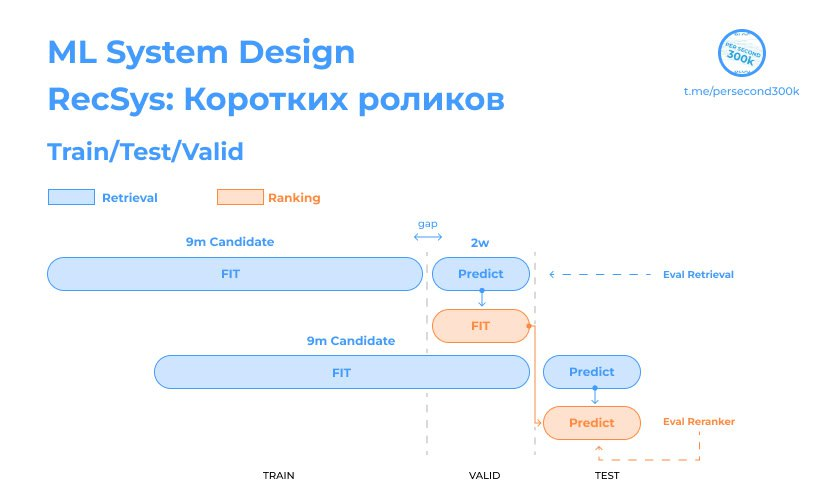

### Подготовка кандиатов для обучения

In [ ]:
# создаём sparse-матрицу формата CSR

user_item_matrix_train_2 = scipy.sparse.csr_matrix(
    (
        df_events_train_2["ratings"],
        (df_events_train_2['user_id'], df_events_train_2['item_id'])
    ),
    dtype=np.int8
) 

In [ ]:
# <Compressed Sparse Row sparse matrix of dtype 'int8'
# 	with 189623725 stored elements and shape (1359368, 703759)>

user_item_matrix_train_2

<Compressed Sparse Row sparse matrix of dtype 'int8'
	with 189623725 stored elements and shape (1359368, 703759)>

In [ ]:
# Создадим и обучим модель

# После урезания матрицы:
# iterations=15 -> 15 min

als_model_2 = AlternatingLeastSquares(factors=50, iterations=15, regularization=0.05, random_state=0)

als_model_2.fit(user_item_matrix_train_2)

/home/mle-user/mle_projects_final/mle-project-sprint-4-v001/.env_recsys_start/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 15/15 [10:19<00:00, 41.31s/it]


In [26]:
# backup

with open("model_als_2.pkl", "wb") as file:
    pickle.dump(als_model_2, file)

In [27]:
# with open("model_als_2.pkl", "rb") as file:
#     als_model_2 = pickle.load(file)

In [11]:
# получим идентификаторы всех пользователей
# (1282243,)

user_ids_2 = df_events_train_2["user_id"].unique()
user_ids_2.shape

(1282243,)

In [29]:
# получаем рекомендации для всех пользователей

# После урезания матрицы:
# 35 min

item_ids, als_scores = als_model_2.recommend(
    user_ids_2,
    user_item_matrix_train_2[user_ids_2],
    filter_already_liked_items=False,
    N=100
)

In [30]:
# backup

with open("item_ids_2.pkl", "wb") as file:
    pickle.dump(item_ids, file)

with open("als_scores_2.pkl", "wb") as file:
    pickle.dump(als_scores, file)

In [31]:
# (1282243, 100)

item_ids.shape

(1282243, 100)

In [32]:
del user_item_matrix_train_2
# del df_events_test
gc.collect()

0

In [ ]:
# # backup

# with open("item_ids_2.pkl", "rb") as file:
#     item_ids = pickle.load(file)

# with open("als_scores_2.pkl", "rb") as file:
#     als_scores = pickle.load(file)

In [13]:
# преобразуем полученные рекомендации в табличный формат

df_candidates = pd.DataFrame({
    "user_id": user_ids_2,
    "item_id": item_ids.tolist(), 
    "score": als_scores.tolist()
})

In [14]:
# backup

df_candidates.to_parquet("candidates_train.parquet")

In [3]:
# # backup

# df_candidates = pd.read_parquet("candidates_train.parquet")

In [4]:
df_candidates = df_candidates.explode(["item_id", "score"], ignore_index=True)

# приводим типы данных

df_candidates["item_id"] = df_candidates["item_id"].astype("int32")
df_candidates["score"] = df_candidates["score"].astype("float32")

In [5]:
df_candidates.shape

(128224300, 3)

In [6]:
df_candidates.head(10)

,user_id,item_id,score
0,0,46383,0.014839
1,0,300249,0.013498
2,0,282221,0.012645
3,0,230504,0.011461
4,0,216207,0.011309
5,0,287483,0.011093
6,0,2772,0.010796
7,0,272333,0.010429
8,0,217208,0.009957
9,0,137653,0.009544


In [7]:
df_candidates.dtypes

user_id      int32
item_id      int32
score      float32
dtype: object

In [8]:
df_candidates.to_parquet("candidates_train.parquet")

### Таргеты

In [11]:
# backup

df_candidates = pd.read_parquet("candidates_train.parquet")

# optimization

df_events_train_labels = df_events_train_labels[["user_id", "item_id"]]

In [12]:
df_candidates.dtypes

user_id      int32
item_id      int32
score      float32
dtype: object

In [13]:
df_events_train_labels.dtypes

user_id    int32
item_id    int32
dtype: object

In [14]:
# 30 sec

# добавляем таргет к кандидатам со значением:
# — 1 для тех item_id, которые пользователь прослушал
# — 0, для всех остальных 

df_events_train_labels["target"] = 1
#df_events_train_labels["target"] = df_events_train_labels["target"].astype("float32")

df_candidates = df_candidates.merge(
    df_events_train_labels[["user_id", "item_id", "target"]],
    on=["user_id", "item_id"],
    how="left"
)

df_candidates["target"] = df_candidates["target"].fillna(0).astype("int32")

In [15]:
# 2 min
# в кандидатах оставляем только тех пользователей, у которых есть хотя бы один положительный таргет

df_candidates = df_candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0).reset_index(drop=True)

In [16]:
# (28 865 700, 4)

df_candidates.shape

(28865700, 4)

In [17]:
df_candidates.head()

,user_id,item_id,score,target
0,10,406413,0.233519,0
1,10,407324,0.183722,0
2,10,429111,0.165771,0
3,10,440161,0.164683,0
4,10,451474,0.156476,0


In [18]:
# backup

df_candidates.to_parquet("candidates_train.parquet")

In [19]:
# 2 min
# для каждого пользователя оставляем только 4 негативных примера

negatives_per_user = 4

candidates_for_train = pd.concat([
    df_candidates[df_candidates["target"]==1],
    df_candidates[df_candidates["target"]==0] \
        .groupby("user_id") \
        .apply(lambda x: x.sample(negatives_per_user, random_state=0))
], ignore_index=True)

In [20]:
del df_candidates
gc.collect()

0

In [21]:
# (1 811 902, 4)

candidates_for_train.shape

(1811902, 4)

In [22]:
candidates_for_train.head()

,user_id,item_id,score,target
0,10,453679,0.106194,1
1,12,307320,0.393030,1
2,12,317489,0.347197,1
3,12,313824,0.333759,1
4,12,314550,0.185529,1


In [23]:
# backup

candidates_for_train.to_parquet("candidates_for_train.parquet")

### Подготовка кандидатов для рекомендаций

In [24]:
candidates_to_rank = pd.read_parquet("personal_als.parquet")

In [25]:
# (132 930 500, 3)

candidates_to_rank.shape

(132930500, 3)

In [26]:
candidates_to_rank.dtypes

user_id      int32
item_id      int32
score      float32
dtype: object

In [28]:
# оставляем только тех пользователей, что есть в тестовой выборке, для экономии ресурсов

# candidates_to_rank = candidates_to_rank[candidates_to_rank["user_id"].isin(df_events_test["user_id"].unique())]

In [27]:
# (132 930 500, 3)

candidates_to_rank.shape

(132930500, 3)

In [28]:
candidates_to_rank.head()

,user_id,item_id,score
0,0,46383,0.013145
1,0,300249,0.012530
2,0,282221,0.011417
3,0,2772,0.011180
4,0,272333,0.010205


### Построение признаков

Построим признаки для ранжирующей модели.

Признаки объектов:
- кол-во альбомов, в которых встречается трек
- кол-во исполнителей трека

Признаки пользователей:
- кол-во прослушанных треков
- период прослушивания в днях

Признаки "пользователь-объект"
- доля треков конкретного жанра среди всех прослушанных

#### Признаки объектов

In [32]:
df_items_features = pd.DataFrame({
    "item_id": df_items["item_id"],
    "n_albums": df_items["albums"].apply(len),
    "n_artists": df_items["artists"].apply(len),
})

In [33]:
# (703759, 3)

df_items_features.shape

(703759, 3)

In [34]:
df_items_features.head()

,item_id,n_albums,n_artists
2,0,3,1
4,1,10,1
6,2,3,1
7,3,49,1
8,4,3,1


In [35]:
df_items_features.dtypes

item_id      int32
n_albums     int64
n_artists    int64
dtype: object

In [37]:
df_items_features[["n_albums", "n_artists"]] = df_items_features[["n_albums", "n_artists"]].astype("int8")

In [38]:
candidates_for_train = candidates_for_train.merge(
    df_items_features,
    on="item_id",
    how="left"
)

In [39]:
candidates_to_rank = candidates_to_rank.merge(
    df_items_features,
    on="item_id",
    how="left"
)

In [40]:
del df_items_features
gc.collect()

654

In [41]:
candidates_for_train.head(3)

,user_id,item_id,score,target,n_albums,n_artists
0,10,453679,0.106194,1,17,1
1,12,307320,0.393030,1,9,1
2,12,317489,0.347197,1,4,1


In [42]:
# backup

candidates_for_train.to_parquet("candidates_for_train.parquet")
candidates_to_rank.to_parquet("candidates_to_rank.parquet")

#### Признаки пользователей

In [44]:
def get_user_features(events):
    """ считает пользовательские признаки """
    
    df_users_features = (
        events.groupby("user_id", as_index=False)
        .agg(
            n_tracks = ("item_seq", "max"),
            min_date = ("started_at", "min"),
            max_date = ("started_at", "max"),
        )
    )
    df_users_features["user_period"] = (df_users_features["max_date"] - df_users_features["min_date"]).dt.days
    df_users_features[["n_tracks", "user_period"]] = df_users_features[["n_tracks", "user_period"]].astype("int16")
    return df_users_features[["user_id", "n_tracks", "user_period"]]

In [45]:
candidates_for_train = candidates_for_train.merge(
    get_user_features(df_events_train_2),
    on="user_id",
)

In [46]:
candidates_to_rank = candidates_to_rank.merge(
    get_user_features(df_events_train),
    on="user_id",
)

In [47]:
candidates_to_rank.dtypes

user_id          int32
item_id          int32
score          float32
n_albums          int8
n_artists         int8
n_tracks         int16
user_period      int16
dtype: object

In [48]:
candidates_for_train.head(3)

,user_id,item_id,score,target,n_albums,n_artists,n_tracks,user_period
0,10,453679,0.106194,1,17,1,26,61
1,10,420991,0.096848,0,2,1,26,61
2,10,497930,0.052209,0,1,1,26,61


In [49]:
# backup

candidates_for_train.to_parquet("candidates_for_train.parquet")
candidates_to_rank.to_parquet("candidates_to_rank.parquet")

#### Парные признаки

In [21]:
def get_item2genre_matrix(df_item_genre):

    '''Функция строит матрицу вида «книга-жанр».
    Индексы строк не соовтетствуют исходным интексам!!! - это новые индексы !!! Поскольку важны жанры
    '''
    max_genre = 0

    # list to build CSR matrix
    genres_csr_data = []
    genres_csr_row_idx = []
    genres_csr_col_idx = []
    
    for index, row in df_item_genre.iterrows():
        row_dict = row.to_dict()
        item_id = row_dict["item_id"]
        genres = row_dict["genres"]
        if len(genres) == 0:
            continue
        for genre in genres:
            genres_csr_data.append(1 / len(genres))
            genres_csr_row_idx.append(item_id)
            genres_csr_col_idx.append(genre)
            max_genre = max(max_genre, genre)

    genres_csr = scipy.sparse.csr_matrix(
        (genres_csr_data, (genres_csr_row_idx, genres_csr_col_idx)),
        shape=(df_item_genre["item_id"].max() + 1, max_genre + 1)
    )
    
    # нормализуем, чтобы сумма оценок принадлежности к жанру была равна 1
    genres_csr = normalize(genres_csr, norm='l1', axis=1)
    
    return genres_csr 

In [22]:
# 1 min

all_items_genres_csr = get_item2genre_matrix(df_items[["item_id", "genres"]])

In [23]:
# <Compressed Sparse Row sparse matrix of dtype 'float64'
# 	with 1164395 stored elements and shape (703759, 1543)>

all_items_genres_csr

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1164395 stored elements and shape (703759, 1543)>

In [24]:
# определяем индексы топ-7 жанров и всех остальных
# [11, 68, 75, 102, 16, 47, 13, 3, 44, 25]
# ['genre_pop',
#  'genre_electronics',
#  'genre_rap',
#  'genre_allrock',
#  'genre_dance',
#  'genre_metal',
#  'genre_alternative',
#  'genre_rusrap',
#  'genre_foreignrap',
#  'genre_soundtrack',
#  'genre_others']

top_genres_index = (all_items_genres_csr.sum(axis=0) * -1).argsort().tolist()[0][:7]
other_genres_index = list(set(all_items_genres_csr.indices) - set(top_genres_index))

top_genres_index

[11, 68, 75, 102, 16, 47, 13]

In [25]:
genres_dict = df_catalog.loc[df_catalog["type"]=="genre", ["id", "name"]].set_index("id").to_dict()["name"]

genres_top_columns = [f"genre_{genres_dict.get(id, id)}" for id in top_genres_index]
genres_others_column = "genre_others"
genre_columns = genres_top_columns + [genres_others_column]

genre_columns

['genre_pop',
 'genre_electronics',
 'genre_rap',
 'genre_allrock',
 'genre_dance',
 'genre_metal',
 'genre_alternative',
 'genre_others']

In [26]:
# составляем таблицу принадлежности книг к жанрам

item_genres = (
    pd.concat([
        # топ жанров
        pd.DataFrame(all_items_genres_csr[:, top_genres_index].toarray(), columns=genres_top_columns),
        # все остальные жанры
        pd.DataFrame(all_items_genres_csr[:, other_genres_index].sum(axis=1), columns=[genres_others_column])
        ],
        axis=1)
    .reset_index()
    .rename(columns={"index": "item_id"})
)

In [27]:
# (703759, 9)

item_genres.shape

(703759, 9)

In [28]:
item_genres.head()

,item_id,genre_pop,genre_electronics,genre_rap,genre_allrock,genre_dance,genre_metal,genre_alternative,genre_others
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# объединяем информацию принадлежности книг к жанрам с основной информацией о книгах

df_items = df_items.merge(item_genres, on="item_id", how="left")

In [30]:
del all_items_genres_csr, item_genres
gc.collect()

0

In [31]:
# (703759, 14)

df_items.shape

(703759, 14)

In [32]:
df_items.head()

,item_id,albums,artists,genres,track_name,artist_names,genre_pop,genre_electronics,genre_rap,genre_allrock,genre_dance,genre_metal,genre_alternative,genre_others
0,0,"[12, 214, 2490809]",[84],[11],Atticus,Noisettes,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11],Don't Upset The Rhythm (Go Baby Go),Noisettes,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,"[12, 214, 2490809]",[84],[11],Sometimes,Noisettes,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,"[12, 214, 60093, 2490809, 10023160, 15635235, ...",[84],[11],Never Forget You,Noisettes,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,"[12, 214, 2490809]",[84],[11],Every Now And Then,Noisettes,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
df_items[genre_columns] = df_items[genre_columns].astype("float32")

df_items = df_items[["item_id"]+genre_columns]

In [35]:
# backup

df_items.to_parquet("df_items_genres.parquet")

In [10]:
# backup

df_items = pd.read_parquet("df_items_genres.parquet")

In [11]:
df_items.dtypes

item_id                int32
genre_pop            float32
genre_electronics    float32
genre_rap            float32
genre_allrock        float32
genre_dance          float32
genre_metal          float32
genre_alternative    float32
genre_others         float32
dtype: object

In [12]:
df_events_train = df_events_train[["item_id", "user_id"]]
df_events_train_2 = df_events_train_2[["item_id", "user_id"]]

In [13]:
df_events_train_2.dtypes

item_id    int32
user_id    int32
dtype: object

In [14]:
def get_user_genres(events, items, item_genre_columns):
    user_genres = (
        events
        .merge(items[["item_id"] + item_genre_columns], on="item_id", how="left")
        [["user_id"]+item_genre_columns]
        .groupby("user_id").mean()
    )
    return user_genres

In [15]:
candidates_for_train = pd.read_parquet("candidates_for_train.parquet")

In [16]:
del df_events_train
del df_events_train_labels
del df_events_test
gc.collect()

0

In [17]:
# 30 sec

df_temp = df_events_train_2.merge(df_items, on="item_id", how="left")

In [18]:
# 30 sec

df_temp = df_temp.drop("item_id", axis=1).groupby("user_id", as_index=False).mean()

In [19]:
df_temp.dtypes

user_id                int32
genre_pop            float32
genre_electronics    float32
genre_rap            float32
genre_allrock        float32
genre_dance          float32
genre_metal          float32
genre_alternative    float32
genre_others         float32
dtype: object

In [20]:
candidates_for_train = candidates_for_train.merge(
    # get_user_genres(df_events_train_2, df_items, genre_columns),
    df_temp,
    on="user_id",
    how="left"
)

In [21]:
# backup

candidates_for_train.to_parquet("candidates_for_train.parquet")

In [15]:
candidates_to_rank = pd.read_parquet("candidates_to_rank.parquet")

In [16]:
del df_events_train_2
del df_events_train_labels
del df_events_test
gc.collect()

0

In [17]:
# 30 sec

df_temp = df_events_train.merge(df_items, on="item_id", how="left")

In [18]:
# 30 sec

df_temp = df_temp.drop("item_id", axis=1).groupby("user_id", as_index=False).mean()

In [19]:
df_temp.dtypes

user_id                int32
genre_pop            float32
genre_electronics    float32
genre_rap            float32
genre_allrock        float32
genre_dance          float32
genre_metal          float32
genre_alternative    float32
genre_others         float32
dtype: object

In [20]:
candidates_to_rank = candidates_to_rank.merge(
    # get_user_genres(df_events_train, df_items, genre_columns),
    df_temp,
    on="user_id",
    how="left",
) 

In [21]:
# backup

candidates_to_rank.to_parquet("candidates_to_rank.parquet")

Сформированные наборы данных с дополнительными признаками:

In [4]:
candidates_for_train = pd.read_parquet("candidates_for_train.parquet")

In [5]:
candidates_to_rank = pd.read_parquet("candidates_to_rank.parquet")

In [6]:
# (1811902, 16)

candidates_for_train.shape

(1811902, 16)

In [7]:
# (132930500, 15)

candidates_to_rank.shape

(132930500, 15)

In [8]:
candidates_for_train.head()

,user_id,item_id,score,target,n_albums,n_artists,n_tracks,user_period,genre_pop,genre_electronics,genre_rap,genre_allrock,genre_dance,genre_metal,genre_alternative,genre_others
0,10,453679,0.106194,1,17,1,26,61,0.173077,0.0,0.096154,0.0,0.269231,0.0,0.0,0.461538
1,10,420991,0.096848,0,2,1,26,61,0.173077,0.0,0.096154,0.0,0.269231,0.0,0.0,0.461538
2,10,497930,0.052209,0,1,1,26,61,0.173077,0.0,0.096154,0.0,0.269231,0.0,0.0,0.461538
3,10,429111,0.165771,0,2,1,26,61,0.173077,0.0,0.096154,0.0,0.269231,0.0,0.0,0.461538
4,10,404851,0.070469,0,1,2,26,61,0.173077,0.0,0.096154,0.0,0.269231,0.0,0.0,0.461538


In [9]:
candidates_to_rank.head()

,user_id,item_id,score,n_albums,n_artists,n_tracks,user_period,genre_pop,genre_electronics,genre_rap,genre_allrock,genre_dance,genre_metal,genre_alternative,genre_others
0,0,46383,0.013145,1,1,26,60,0.18,0.04,0.16,0.02,0.04,0.0,0.0,0.56
1,0,300249,0.012530,4,1,26,60,0.18,0.04,0.16,0.02,0.04,0.0,0.0,0.56
2,0,282221,0.011417,1,1,26,60,0.18,0.04,0.16,0.02,0.04,0.0,0.0,0.56
3,0,2772,0.011180,10,1,26,60,0.18,0.04,0.16,0.02,0.04,0.0,0.0,0.56
4,0,272333,0.010205,8,1,26,60,0.18,0.04,0.16,0.02,0.04,0.0,0.0,0.56


## Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [10]:
candidates_for_train.columns

Index(['user_id', 'item_id', 'score', 'target', 'n_albums', 'n_artists',
       'n_tracks', 'user_period', 'genre_pop', 'genre_electronics',
       'genre_rap', 'genre_allrock', 'genre_dance', 'genre_metal',
       'genre_alternative', 'genre_others'],
      dtype='object')

In [11]:
genre_columns = ['genre_pop',
 'genre_electronics',
 'genre_rap',
 'genre_allrock',
 'genre_dance',
 'genre_metal',
 'genre_alternative',
#  'genre_rusrap',
#  'genre_foreignrap',
#  'genre_soundtrack',
 'genre_others']

In [12]:
# задаём имена колонок признаков и таргета

features = [
    'score', 
    'n_albums', 'n_artists',
    'n_tracks', 'user_period',
] + genre_columns

target = 'target'

features

['score',
 'n_albums',
 'n_artists',
 'n_tracks',
 'user_period',
 'genre_pop',
 'genre_electronics',
 'genre_rap',
 'genre_allrock',
 'genre_dance',
 'genre_metal',
 'genre_alternative',
 'genre_others']

In [13]:
# создаём Pool

train_data = Pool(
    data=candidates_for_train[features], 
    label=candidates_for_train[target]
)

In [14]:
# инициализируем модель CatBoostClassifier

cb_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    random_seed=0,
)

In [15]:
# тренируем модель
# 30 sec

cb_model.fit(train_data)

0:	learn: 0.6788854	total: 279ms	remaining: 4m 38s
100:	learn: 0.5981348	total: 16.1s	remaining: 2m 23s
200:	learn: 0.5905683	total: 31.7s	remaining: 2m 6s
300:	learn: 0.5860120	total: 47.6s	remaining: 1m 50s
400:	learn: 0.5828750	total: 1m 3s	remaining: 1m 34s
500:	learn: 0.5803871	total: 1m 19s	remaining: 1m 18s
600:	learn: 0.5784595	total: 1m 35s	remaining: 1m 3s
700:	learn: 0.5768670	total: 1m 51s	remaining: 47.4s
800:	learn: 0.5754627	total: 2m 7s	remaining: 31.6s
900:	learn: 0.5741706	total: 2m 23s	remaining: 15.7s
999:	learn: 0.5730230	total: 2m 38s	remaining: 0us



<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Ранжирующая модель построена.
</div>


In [16]:
# Проверка важности признаков

feature_importance = pd.DataFrame(cb_model.get_feature_importance(), 
    index=features, 
    columns=["fi"]
).sort_values("fi", ascending=False)

print(feature_importance)

                          fi
n_albums           49.025721
score              13.048378
user_period        10.334962
n_artists           5.267561
n_tracks            4.645066
genre_allrock       3.998575
genre_dance         2.741152
genre_others        2.328619
genre_rap           2.011282
genre_pop           1.975770
genre_metal         1.659584
genre_alternative   1.574450
genre_electronics   1.388881


Получим топ-100 самых релевантных рекомендация для каждого пользователя, используя обученную модель.

In [17]:
# 2 min

inference_data = Pool(data=candidates_to_rank[features])

predictions = cb_model.predict_proba(inference_data)

In [18]:
final_recommendations = candidates_to_rank[["user_id", "item_id"]]
final_recommendations["score"] = predictions[:, 1]

/tmp/ipykernel_4248/2859190516.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_recommendations["score"] = predictions[:, 1]


In [19]:
# backup

final_recommendations.to_parquet("recommendations.parquet")

In [13]:
# backup

final_recommendations = pd.read_parquet("recommendations.parquet")

In [4]:
# 3 min

final_recommendations = final_recommendations.sort_values(["user_id", "score"], ascending=[True, False]).groupby("user_id").head(100)

In [14]:
# (132930500, 3)

final_recommendations.shape

(132930500, 3)

In [15]:
final_recommendations.head()

,user_id,item_id,score
19,0,298799,0.334735
21,0,219419,0.334735
25,0,477767,0.334735
38,0,269537,0.330865
49,0,241390,0.330865


In [16]:
final_recommendations.dtypes

user_id      int32
item_id      int32
score      float64
dtype: object

In [17]:
final_recommendations["score"] = final_recommendations["score"].astype("float32")

In [26]:
final_recommendations.dtypes

user_id      int32
item_id      int32
score      float32
dtype: object

### Сохранение

In [18]:
# 1 min

final_recommendations.to_parquet("recommendations.parquet")

---

## Сохранение рекомендаций

In [19]:
session = boto3.session.Session()
s3 = boto3.client(
    service_name = 's3',
    endpoint_url='https://storage.yandexcloud.net',
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"))

bucket_name = os.getenv("S3_BUCKET_NAME")

In [20]:
s3.upload_file("top_popular.parquet", bucket_name, "recsys/recommendations/top_popular.parquet")

In [21]:
s3.upload_file("personal_als.parquet", bucket_name, "recsys/recommendations/personal_als.parquet")

In [22]:
s3.upload_file("similar.parquet", bucket_name, "recsys/recommendations/similar.parquet")

In [23]:
s3.upload_file("recommendations.parquet", bucket_name, "recsys/recommendations/recommendations.parquet")

In [24]:
# files = []
# sizes = []


# if s3.list_objects(Bucket=bucket_name).get('Contents'):
#     for key in s3.list_objects(Bucket=bucket_name)['Contents']:
#         cur_key = key['Key']
#         response = s3.head_object(Bucket = bucket_name, Key = cur_key)
#         cur_size = response['ContentLength']
#         print(f"file {cur_key} weights {cur_size} bytes")
#         files.append(cur_key)
#         sizes.append(cur_size)

# total_weight = sum(sizes)
# print(f"Total weight of all files in bucket = {total_weight}")

In [25]:
if s3.list_objects(Bucket=bucket_name).get('Contents'):
    for key in s3.list_objects(Bucket=bucket_name)['Contents']:
        cur_key = key['Key']
        response = s3.head_object(Bucket = bucket_name, Key = cur_key)
        cur_size = response['ContentLength']
        if cur_key.startswith("recsys"):
            print(f"file {cur_key} weights {cur_size} bytes")

file recsys/data/events.parquet weights 1454441905 bytes
file recsys/data/id_dict_items.parquet weights 6343130 bytes
file recsys/data/id_dict_users.parquet weights 12620419 bytes
file recsys/data/items.parquet weights 32987125 bytes
file recsys/recommendations/personal_als.parquet weights 841611321 bytes
file recsys/recommendations/recommendations.parquet weights 1391605337 bytes
file recsys/recommendations/similar.parquet weights 66492083 bytes
file recsys/recommendations/top_popular.parquet weights 3660 bytes


---

## Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

---

Используются метрики, традиционные для задач бинарной классификации: precision, recall, и их производные, например, F1.

Precision вычисляется по формуле: 

$$
precision=\frac{TP}{TP+FP}
$$​

Метрика показывает, какая доля объектов, отнесённых моделью к положительному классу, действительно относится к этому классу. В контексте задачи рекомендаций это означает, что рекомендованный айтем действительно нравится пользователю (есть в тестовой выборке).

Recall вычисляется по формуле: 

$$
recall=\frac{TP}{TP+FN}
$$

Recall измеряет способность модели обнаруживать все истинные случаи в данных. В контексте задачи рекомендаций это означает, что модель смогла «найти» те айтемы, которые представлены в тестовой выборке.

Посчитаем recall и precision. Для этого события в тестовой выборке и рекомендации для одних и тех же пользователей разметим признаками:
- `gt` (ground truth): объект есть в тестовой выборке;
- `pr` (predicted): объект есть в рекомендациях.

Теперь разметим признаки бинарной классификации:
- `TP`: объект есть и в тестовой выборке, и в рекомендациях (истинная рекомендация),
- `FP`: объекта нет в тестовой выборке, но он есть в рекомендациях (ложноположительная рекомендация),
- `FN`: объект есть в тестовой выборке, но его нет в рекомендациях (ложноотрицательная рекомендация)


<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Отлично! Ключевые метрики описаны!
</div>


In [12]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()
    
    # оставляет только те item_id, которые были в events_train, 
    # т. к. модель не имела никакой возможности давать рекомендации для новых айтемов
    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]


    recs_for_common_users = recs_for_common_users.sort_values("score", ascending=False)
    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = (
        events_for_common_users[["user_id", "item_id", "gt"]]
        .merge(
            recs_for_common_users[["user_id", "item_id", "score"]], 
            on=["user_id", "item_id"],
            how="outer",
        )
    )

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = events_recs_common["score"].notna()

    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common 

In [13]:
def compute_cls_metrics(events_recs_for_binary_metric):
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    f1 = 2*precision*recall/(precision+recall)

    return precision, recall, f1

In [14]:
def compute_spec_metrics(events_train, items, recs, top_k=None):
    cov_items = np.isin(
        recs["item_id"].unique(),
        items["item_id"].unique(),
    ).sum() / items["item_id"].nunique()
    print("cov_items calculated")

    events_train["familar"] = 1

    # Возьмем 100_000 сэмплов, т.к. на полном наборе данных ядро падает
    recs = recs.sample(100_000).merge(
        # events_train[["user_id", "item_id", "familar"]], on=["user_id", "item_id"], how="left",
        events_train, on=["user_id", "item_id"], how="left",
    )
    print("merged")

    recs["familar"] = recs["familar"].fillna(0).astype("int8")
    recs = recs.sort_values("score", ascending=False)
    print("sorted")

    # посчитаем novelty по пользователям
    novelty_k = (1 - recs.groupby("user_id").agg({"familar": lambda x: x.head(top_k).mean()}))

    # посчитаем средний novelty
    return cov_items, novelty_k["familar"].mean()

In [12]:
del df_events_train_labels
gc.collect()

0

In [8]:
df_events_train = df_events_train[["item_id", "user_id"]]
df_events_train_2 = df_events_train_2[["item_id", "user_id"]]

In [14]:
metrics = {}

In [19]:
recs = pd.read_parquet("top_popular.parquet")

In [20]:
recs = pd.concat([recs] * df_events_test["user_id"].nunique())

In [21]:
recs["user_id"] = df_events_test["user_id"].unique().repeat(100)

In [22]:
# (77264600, 3)

recs.shape

(77264600, 3)

In [23]:
recs.head()

,item_id,score,user_id
0,551709,1.000000,3
1,585852,0.996666,3
2,343675,0.924520,3
3,494146,0.897710,3
4,496367,0.866444,3


In [24]:
recs.dtypes

item_id      int32
score      float64
user_id      int32
dtype: object

In [25]:
precision, recall, f1 = compute_cls_metrics(
    process_events_recs_for_binary_metrics(
        df_events_train_2,
        df_events_test,
        recs,
        top_k=5,
    )
)
print(precision, recall, f1)

cov, nov = compute_spec_metrics(df_events_train, df_items, recs, top_k=5)
print(cov, nov)

metrics["top_popular"] = {
    "precision@5": precision,
    "recall@5": recall,
    "f1@5": f1,
    "cov@5": cov,
    "nov@5": nov,
}

Common users: 772646
0.01077802771256177 0.004310255713213981 0.006157898047684571
cov_items calculated
merged
sorted
0.00014209409755328172 0.9615976815304745


: 

In [26]:
for filename in ["personal_als", "recommendations"]:
    print(filename)
    recs = pd.read_parquet(f"{filename}.parquet")

    precision, recall, f1 = compute_cls_metrics(
        process_events_recs_for_binary_metrics(
            df_events_train_2,
            df_events_test,
            recs,
            top_k=5,
        )
    )
    print(precision, recall, f1)

    cov, nov = compute_spec_metrics(df_events_train, df_items, recs, top_k=5)
    print(cov, nov)

    metrics[filename] = {
        "precision@5": precision,
        "recall@5": recall,
        "f1@5": f1,
        "cov@5": cov,
        "nov@5": nov,
    }

personal_als
Common users: 742583
0.007177918158643544 0.00587652327974564 0.006462352810490309
cov_items calculated
merged
sorted
0.014256300807520756 0.8305673685302355
recommendations
Common users: 742583
0.016303362721742896 0.010337351757558061 0.012652332985788434
cov_items calculated


In [15]:
for filename in ["recommendations"]:
    print(filename)
    recs = pd.read_parquet(f"{filename}.parquet")

    cov = np.isin(
        recs["item_id"].unique(),
        df_items["item_id"].unique(),
    ).sum() / df_items["item_id"].nunique()
    print("cov_items calculated")

    print(cov)

recommendations
cov_items calculated
0.014256300807520756


: 

In [9]:
for filename in ["recommendations"]:
    print(filename)
    recs = pd.read_parquet(f"{filename}.parquet")

    df_events_train["familar"] = 1

    # Возьмем 100_000 сэмплов, т.к. на полном наборе данных ядро падает
    recs = recs.sample(100_000).merge(
        # events_train[["user_id", "item_id", "familar"]], on=["user_id", "item_id"], how="left",
        df_events_train, on=["user_id", "item_id"], how="left",
    )
    print("merged")

    recs["familar"] = recs["familar"].fillna(0).astype("int8")
    recs = recs.sort_values("score", ascending=False)
    print("sorted")

    # посчитаем novelty по пользователям
    novelty_k = (1 - recs.groupby("user_id").agg({"familar": lambda x: x.head(5).mean()}))

    # посчитаем средний novelty
    nov = novelty_k["familar"].mean()

    print(nov)

recommendations
merged
sorted
0.8353075525564495


In [15]:
# Поскольку ядро постоянно падает и молностью прогнать расчеты невозможно, заполним вручную по выведенным принтами значениям:

metrics = {
    'top_popular': {
        'precision': 0.01077802771256177,
        'recall': 0.004310255713213981,
        'f1': 0.006157898047684571,
        'cov': 0.00014209409755328172,
        'nov': 0.9615976815304745,
    },
    'personal_als': {
        'precision': 0.007177918158643544,
        'recall': 0.00587652327974564,
        'f1': 0.006462352810490309,
        'cov': 0.014256300807520756,
        'nov': 0.8305673685302355,
    },
    'recommendations': {
        'precision': 0.016303362721742896,
        'recall': 0.010337351757558061,
        'f1': 0.012652332985788434,
        'cov': 0.014256300807520756,
        'nov': 0.8353075525564495,
    }
}

In [16]:
metrics

{'top_popular': {'precision': 0.01077802771256177,
  'recall': 0.004310255713213981,
  'f1': 0.006157898047684571,
  'cov': 0.00014209409755328172,
  'nov': 0.9615976815304745},
 'personal_als': {'precision': 0.007177918158643544,
  'recall': 0.00587652327974564,
  'f1': 0.006462352810490309,
  'cov': 0.014256300807520756,
  'nov': 0.8305673685302355},
 'recommendations': {'precision': 0.016303362721742896,
  'recall': 0.010337351757558061,
  'f1': 0.012652332985788434,
  'cov': 0.014256300807520756,
  'nov': 0.8353075525564495}}

In [17]:
df_metrics = pd.DataFrame(metrics)

In [18]:
df_metrics

,top_popular,personal_als,recommendations
precision,0.010778,0.007178,0.016303
recall,0.004310,0.005877,0.010337
f1,0.006158,0.006462,0.012652
cov,0.000142,0.014256,0.014256
nov,0.961598,0.830567,0.835308


In [19]:
df_metrics.style.format("{:.3%}")

,top_popular,personal_als,recommendations
precision,1.078%,0.718%,1.630%
recall,0.431%,0.588%,1.034%
f1,0.616%,0.646%,1.265%
cov,0.014%,1.426%,1.426%
nov,96.160%,83.057%,83.531%


# === Выводы, метрики ===

1. До ноября 2022 года тренд на увеличение кол-ва пользоватлей.<br/>
С ноября 2022 идет снижение кол-ва пользователей.<br/>
Вводимая рекомендательная система должна помочь удержать пользователей.<br/>
Необходимо проведение АВ-тестирования.

2. **Построены рекомендации:**
- Топ-100 популярных треков (можно рекомендовать внось пришедшим пользователям на "холодном" старте)
- Персональные рекомендации основанные на коллаборативном подходе (модель ALS)
- Похожие треки (можно использовать для онлайн рекомендаций)
- Персональные рекомендации оснвоанные на двухстадийновм подходе

Сгенерированы и сохранени на диске и в хранилище персональные рекомендации для ***1 329 305*** пользователей

3. **Получены метрики на тестовой выборке:**

|Метрика|Топ-100 популярныз|Персональные ALS|Двухстадийный подход|
|---|---|---|---|
|precision@5|1.078%|0.718%|**1.630%**|
|recall@5|0.431%|0.588%|**1.034%**|
|f1@5|0.616%|0.646%|**1.265%**|
|coverage@5|0.014%|**1.426%**|**1.426%**|
|novelty@5|**96.160%**|83.057%|83.531%|

- Лучшие метрики по "Двухстадийному подходу"
- "Новизна" лучше по топ-100 трекам
- Использованне дополнительные признаки:
  - кол-во альбомов, в которых встречается трек
  - кол-во исполнителей трека
  - кол-во прослушанных треков
  - период прослушивания в днях
  - доля треков конкретного жанра среди всех прослушанных
- Наиболее значимые признаки:
  - кол-во альбомов, в которых встречается трек
  - оценки модели ALS
  - полный период прослушивания музыки пользователем в днях


4. **Выделенных ресурсов недостаточно. Требуется оптимизация процессов расчета. Способы оптимизации:**
- Сокращение матрицы:
  - Удаление объектов с неполными данными
  - Удаление объектов с редкими взаимодействиями
  - Удаление клиентов с редкими взаимодействиями
  - Удаление клиентов с выбросами по взаимодействиям
- Оптимизация вычислений:
  - Замена типов данных на использующие меньший объем памяти
  - Чистка пямяти от нейиспользуемых переменных
  - Потапные вычисления с сохранением промежуточных результатов

<b>Комментарий от ревьюера v1</b>


    
# Общий вывод

<div class="alert alert-block alert-success">
    

Спасибо за работу, у тебя получился отличный проект, мне было приятно его проверять!\
Выводы очень развернутые и верные!
Удалось протестировать различные алгоритмы для формирования рекомендаций.  
Есть небольшие советы, просьба ознакомиться с ними. Я готов принять твой проект, если у тебя нет ко мне вопросов - присылай мне его обратно и я его приму.\
Если есть вопросы или желание улучшить твой проект - оставь вопросы комментарии после этой ячейки. Постараюсь тебе помочь с ответами и улучшением твоего проекта! 
</div>